## Imports

In [1]:
import pandas as pd
import numpy as np
import MDP as mdp
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import kernel_ridge
from tqdm import tqdm
from math import log, exp, sqrt

## Read Data

In [2]:
X_data = pd.read_csv('./data/X_data.csv')
X_data = np.array(X_data.values.tolist())
X_data = X_data[:,3]
X_data = X_data.reshape((84,720))

Y_data = pd.read_csv('./data/Y_data.csv')
Y_data = np.array(Y_data.values.tolist())
Y_data = Y_data[:,1]
Y_data = Y_data.reshape((84,720))

block_names = pd.read_csv('./data/block_names.csv')
block_names = np.array(block_names['0'].tolist())

## Split Training/Test Data

In [40]:
x_train, x_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=1/7, random_state=42)
print('Training Data Size:', len(x_train))
print('Testing Data Size:', len(x_test))

Training Data Size: 72
Testing Data Size: 12


## Clustering Blocks

In [53]:
n_clusters = 4
methods = "gm"
if methods == "gm":
    gm = GaussianMixture(n_components=n_clusters).fit(x_train)
    clusters = gm.predict(x_train)
else:
    kmeans = KMeans(n_clusters)
    kmeans.fit(x_train)
    clusters = kmeans.predict(x_train)


In [54]:
x_bins = [[], [], [], []]
y_bins = [[], [], [], []]
label_bins = [[], [], [], []]
for i, cluster in enumerate(clusters):
    x_bins[cluster].append(x_train[i])
    y_bins[cluster].append(y_train[i])
    label_bins[cluster].append(block_names[i])

In [55]:
# To visualize the data use PCA to reduce dimension to 2 and plot scatter plot
pca_2d = PCA(n_components=2)
PCA_2d = pca_2d.fit_transform(x_train)

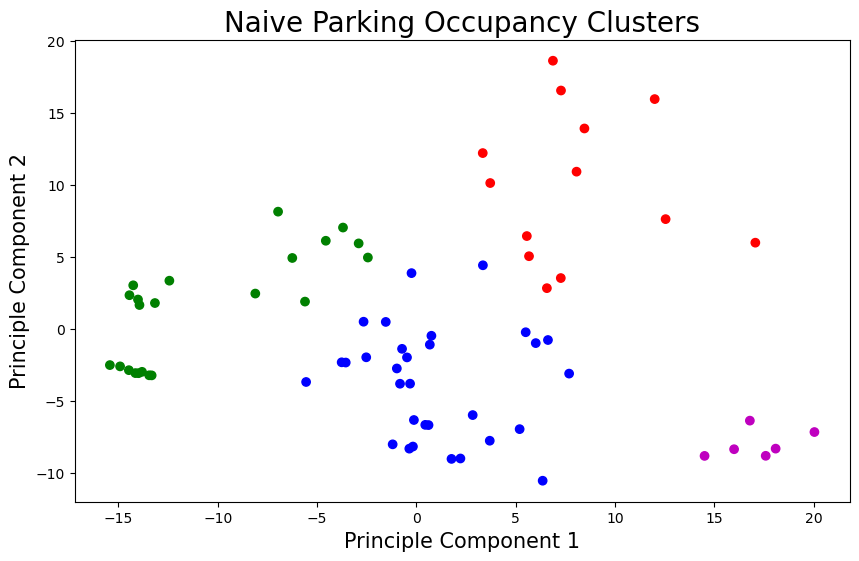

In [56]:
colors = ['b', 'g', 'r', 'm', 'y']
color_map = []
for index in clusters:
    color_map.append(colors[index])
plt.figure(figsize=(10,6))
plt.scatter(PCA_2d[:,0], PCA_2d[:,1], color=color_map)
plt.title("Naive Parking Occupancy Clusters", fontsize=20)
plt.ylabel("Principle Component 2", fontsize=15)
plt.xlabel("Principle Component 1", fontsize=15)
plt.show()

 ## Based Case Test

In [57]:
lambda_val = 0.1
gamma = 0.001
rrg = kernel_ridge.KernelRidge(alpha=lambda_val, kernel='rbf', gamma=gamma)

In [58]:
rrg.fit(x_train, y_train)
y_pred = rrg.predict(x_test)
mae = np.mean(np.abs(y_test-y_pred))
print('Base Case Accuracy:', 1-mae)

Base Case Accuracy: 0.8798653098369773


## Q-Learning

In [59]:
train_data = (x_bins, y_bins)
test_data = (x_test, y_test)
max_bins = [len(x_bins[i]) for i in range(n_clusters)]
print('max bins:', max_bins)

max bins: [31, 22, 13, 6]


In [74]:
model = mdp.BanditMDP(train_data, test_data, max_bins)
samples = 36
model.set_goal(samples)

In [75]:
# Need about 10000000 iterations to converge
n_iteration = 10000000
for i in tqdm(range(n_iteration)):
    model.run_iteration()

100%|██████████████████████████████████████████████████████████████████| 10000000/10000000 [00:59<00:00, 169186.49it/s]


In [76]:
model.get_policy()

In [77]:
sol = model.get_solution()

curr_state [0, 0, 0, 0]
action: 1
curr_state [1, 0, 0, 0]
action: 1
curr_state [2, 0, 0, 0]
action: 1
curr_state [3, 0, 0, 0]
action: 1
curr_state [4, 0, 0, 0]
action: 1
curr_state [5, 0, 0, 0]
action: 1
curr_state [6, 0, 0, 0]
action: 1
curr_state [7, 0, 0, 0]
action: 1
curr_state [8, 0, 0, 0]
action: 1
curr_state [9, 0, 0, 0]
action: 1
curr_state [10, 0, 0, 0]
action: 1
curr_state [11, 0, 0, 0]
action: 1
curr_state [12, 0, 0, 0]
action: 1
curr_state [13, 0, 0, 0]
action: 1
curr_state [14, 0, 0, 0]
action: 1
curr_state [15, 0, 0, 0]
action: 1
curr_state [16, 0, 0, 0]
action: 1
curr_state [17, 0, 0, 0]
action: 1
curr_state [18, 0, 0, 0]
action: 2
curr_state [18, 1, 0, 0]
action: 2
curr_state [18, 2, 0, 0]
action: 2
curr_state [18, 3, 0, 0]
action: 2
curr_state [18, 4, 0, 0]
action: 2
curr_state [18, 5, 0, 0]
action: 2
curr_state [18, 6, 0, 0]
action: 2
curr_state [18, 7, 0, 0]
action: 2
curr_state [18, 8, 0, 0]
action: 2
curr_state [18, 9, 0, 0]
action: 2
curr_state [18, 10, 0, 0]
acti

In [78]:
index = np.argsort(sol)[::-1][:2]
print(index)

[1 0]


## RL case

In [79]:
rlx_train = np.concatenate((x_bins[index[0]], x_bins[index[1]]))
rly_train = np.concatenate((y_bins[index[0]], y_bins[index[1]]))
rrg.fit(rlx_train, rly_train)
y_pred = rrg.predict(x_test)
mae = np.mean(np.abs(y_test-y_pred))
print('Base Case Accuracy:', 1-mae)

Base Case Accuracy: 0.874224527336446


In [80]:
index = [2,3]
rlx_train = np.concatenate((x_bins[index[0]], x_bins[index[1]]))
rly_train = np.concatenate((y_bins[index[0]], y_bins[index[1]]))
rrg.fit(rlx_train, rly_train)
y_pred = rrg.predict(x_test)
mae = np.mean(np.abs(y_test-y_pred))
print('Base Case Accuracy:', 1-mae)

Base Case Accuracy: 0.8036371740553788
